In [3]:
# Denoising demonstration
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision.transforms.functional import gaussian_blur
import numpy as np
from random import randint
from torch import fft
from IPython.display import clear_output

device = torch.device('cuda:0') # use the first GPU on this system

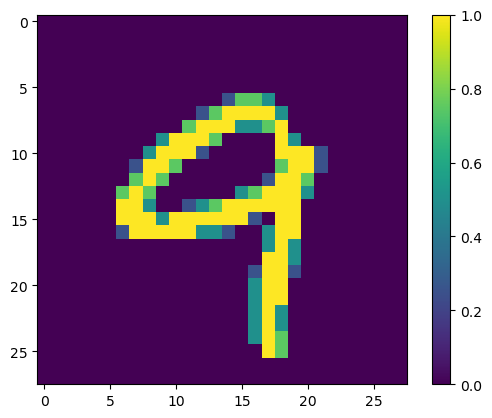

In [19]:
batch_size=32

transform = transforms.ToTensor()
dataset_train = datasets.MNIST(root='data',train=True,download=True,transform=transform)
dataset_val = datasets.MNIST(root='data',train=False,download=True,transform=transform)

dataloader_train = DataLoader(dataset_train, batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size, shuffle=False)

img = next(iter(dataloader_train))[0][1].squeeze()
plt.imshow(img)
plt.colorbar()
plt.show()

In [173]:
# CNN neural network based roughly on Stevens ch 8
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # define network elements
        self.conv1 = nn.Conv2d(1,16,kernel_size=3,padding=1)
        self.act1 = nn.ReLU()
        self.pool1=nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16,16,kernel_size=3,padding=1)
        self.act2=nn.ReLU()
        self.pool2=nn.MaxPool2d(2)
        self.fc1=nn.Linear(7*7*16,32)
        self.act3=nn.ReLU()
        self.fc2=nn.Linear(32,10)

        # initialize
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.constant_(m.bias,0)
        
    def forward(self,x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1,7*7*16)
        out = self.act3(self.fc1(out))
        out = F.softmax(self.fc2(out),dim=1)
        return out
    
net = Net().to(device)

In [163]:
# (optional) load a saved model
net.load_state_dict(torch.load("classification_demo.pth", weights_only=True))
net.to(device)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (act3): ReLU()
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

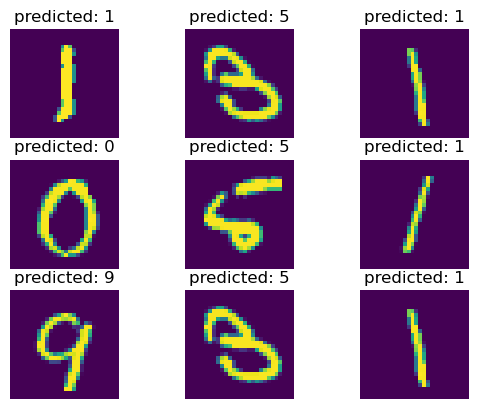

In [171]:
# quick check running data through the network
data = next(iter(dataloader_val))
x = data[0].to(device) # image
y = data[1] # label (target)

net.eval()
with torch.no_grad():
    yhat = net(x) # estimated label
    
maxval, maxind = yhat.max(dim=1)
predicted = maxind

# show a random selection of images and labels
for plotInd in range(9):
    ind = randint(0,len(x)-1)
    
    plt.subplot(3,3,plotInd+1)
    plt.imshow(x[ind].cpu().squeeze())
    plt.title(f'predicted: {predicted[ind]}')
    plt.axis('off')

plt.show()


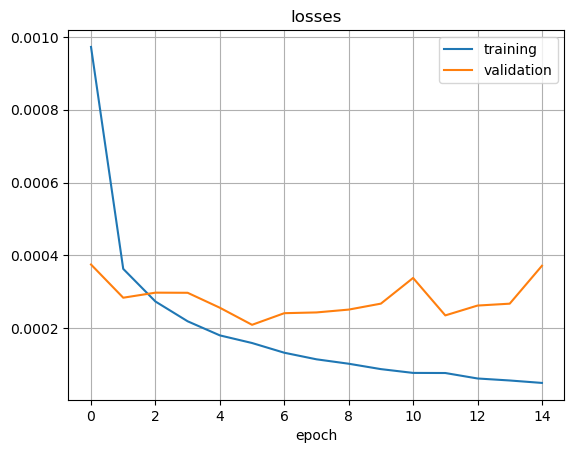

KeyboardInterrupt: 

In [175]:
# training loop
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = nn.BCELoss() # binary cross-entropy loss

loss_train_vec = [] # history of training dataset loss
loss_val_vec = [] # history of validation set loss

n_epochs = 100

for epoch in range(n_epochs):
    # run through training set
    net.train()
    loss_this_epoch = 0
    n_samples = 0
    for data, label in dataloader_train:
        # prep data
        x = data.to(device)
        y = F.one_hot(label,10).to(torch.float).to(device) # convert label to one-hot coding

        # pass through network and evaluate loss function
        yhat = net(x)
        loss = loss_fn(yhat, y)

        # gradient descent step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_this_epoch += loss.sum()
        n_samples += len(x)

    loss_this_epoch = loss_this_epoch / n_samples
    loss_train_vec += [loss_this_epoch.item()]

    # run through validation set
    net.eval()
    loss_this_epoch = 0
    n_samples = 0
    for data, label in dataloader_val:
        with torch.no_grad(): # DON'T CALCULATE GRADIENTS!
            x = data.to(device)
            y = F.one_hot(label,10).to(torch.float).to(device) # convert label to one-hot coding

            # pass through network and evaluate loss function
            yhat = net(x)
            loss = loss_fn(yhat, y)
    
            loss_this_epoch += loss.sum()
            n_samples += len(x)
    
    loss_this_epoch = loss_this_epoch / n_samples
    loss_val_vec += [loss_this_epoch.item()]

    # save the model if it achieved a minimum validation loss
    if loss_val_vec[-1] == min(loss_val_vec):
        torch.save(net.state_dict(), "classification_demo.pth")

    clear_output(wait=True)
    plt.plot(loss_train_vec)
    plt.plot(loss_val_vec)
    plt.title('losses')
    plt.xlabel('epoch')
    plt.legend(['training','validation'])
    plt.grid()
    plt.show()
        

In [149]:
# your turn: change one thing above and run it again. A few ideas
# - change batch size
# - change learning rate
# - change from Adam to SGD optimizer
# - number of channels per convolutional filter
# - number of layers in the network
# - number of neurons in FC1
# - change ReLU to LeakyReLU or Sigmoid activation function
# - change binary cross entropy to L1 or MSE loss functions

0.00023051418247632682

100%|██████████████████████████████████████████████████████████████████| 26421880/26421880 [00:27<00:00, 961568.80it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 217461.36it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:11<00:00, 398183.21it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



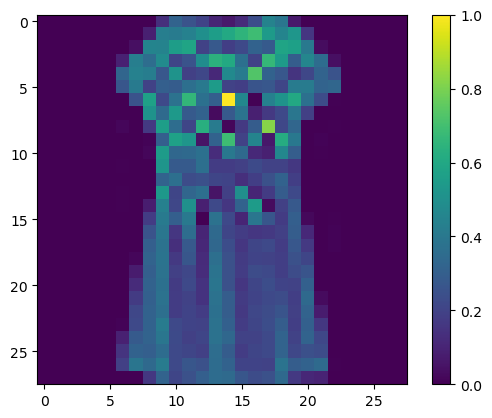

In [181]:
# try something out of distribution
batch_size=32

transform = transforms.ToTensor()
dataset_ood = datasets.FashionMNIST(root='data',train=False,download=True,transform=transform)

dataloader_ood = DataLoader(dataset_ood, batch_size, shuffle=True)

img = next(iter(dataloader_ood))[0][1].squeeze()
plt.imshow(img)
plt.colorbar()
plt.show()

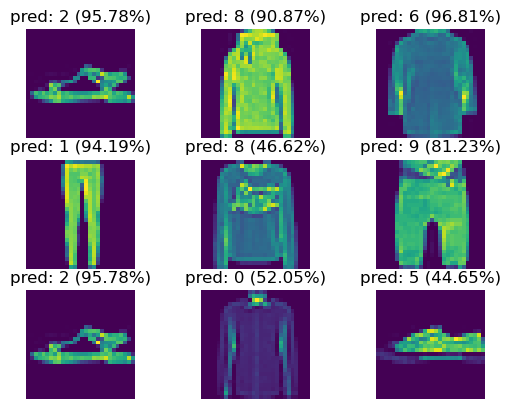

In [201]:
# quick check running data through the network
data = next(iter(dataloader_ood))
x = data[0].to(device) # image
y = data[1] # label (target)

net.eval()
with torch.no_grad():
    yhat = net(x) # estimated label
    
maxval, maxind = yhat.max(dim=1)
predicted = maxind
confidence = maxval

# show a random selection of images and labels
for plotInd in range(9):
    ind = randint(0,len(x)-1)
    
    plt.subplot(3,3,plotInd+1)
    plt.imshow(x[ind].cpu().squeeze())
    plt.title(f'pred: {predicted[ind]} ({maxval[ind]*100 :.2f}%)')
    plt.axis('off')

plt.show()